In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/competitions/cpe-ai-openhouse-loan-approval-prediction/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rokabpy
Your Kaggle Key: ··········


100%|██████████| 1.54M/1.54M [00:00<00:00, 526MB/s]


Extracting archive ./cpe-ai-openhouse-loan-approval-prediction/cpe-ai-openhouse-loan-approval-prediction.zip to ./cpe-ai-openhouse-loan-approval-prediction


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
train = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/train.csv')
final = pd.read_csv('/content/cpe-ai-openhouse-loan-approval-prediction/Loan Approval Prediction Data/test.csv')

train = train.drop(columns=['id'])
id_final = final.id
final = final.drop(columns=['id'])

In [4]:
def preparation(df):
  df = df.rename(columns={
      'person_age' : 'age',
      'person_income' : 'income',
      'person_home_ownership' : 'home',
      'person_emp_length' : 'emp',
      'loan_intent' : 'intent',
      'loan_grade' : 'gra',
      'loan_amnt' : 'amnt',
      'loan_int_rate' : 'rate',
      'loan_percent_income' : 'percome',
      'cb_person_default_on_file' : 'file',
      'cb_person_cred_hist_length' : 'cred',
      'loan_status' : 'status'
  })
  df = pd.get_dummies(df, columns=['home', 'intent', 'gra', 'file'], dtype=int)
  df = df.fillna(df.median())
  return df

train = preparation(train)
final = preparation(final)

<Axes: >

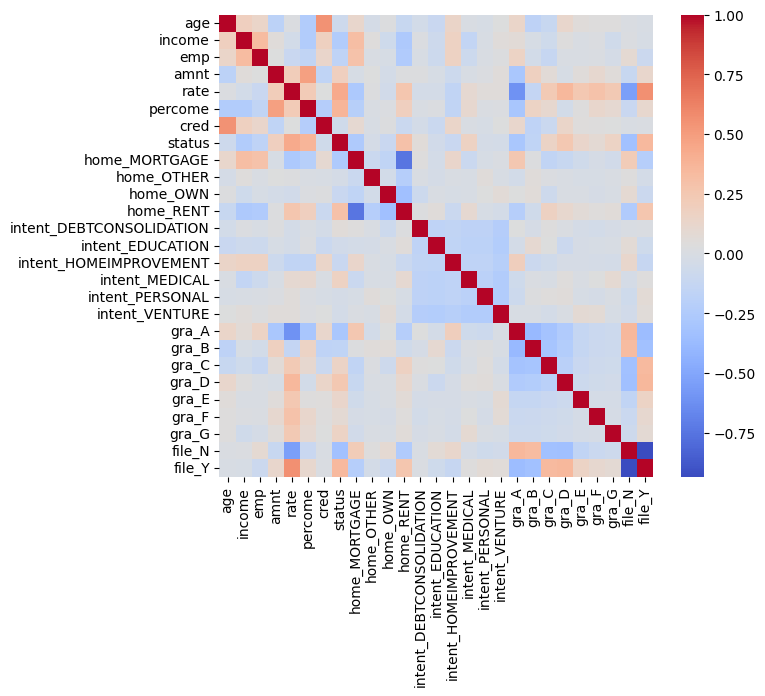

In [5]:
cor = train.corr()
plt.figure(figsize=(7,6))
sns.heatmap(cor, annot=False, cmap='coolwarm')

In [6]:
x = train.iloc[:, :-1]
y = train.iloc[:, -1]
norm_x = StandardScaler().fit_transform(x)
norm_final = StandardScaler().fit_transform(final)
x = pd.DataFrame(norm_x, columns=x.columns)
final = pd.DataFrame(norm_final, columns=final.columns)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25312 entries, 12056 to 23654
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       25312 non-null  float64
 1   income                    25312 non-null  float64
 2   emp                       25312 non-null  float64
 3   amnt                      25312 non-null  float64
 4   rate                      25312 non-null  float64
 5   percome                   25312 non-null  float64
 6   cred                      25312 non-null  float64
 7   status                    25312 non-null  float64
 8   home_MORTGAGE             25312 non-null  float64
 9   home_OTHER                25312 non-null  float64
 10  home_OWN                  25312 non-null  float64
 11  home_RENT                 25312 non-null  float64
 12  intent_DEBTCONSOLIDATION  25312 non-null  float64
 13  intent_EDUCATION          25312 non-null  float64
 14  intent_

In [8]:
x = x.to_numpy()
y = y.to_numpy()
y = (y*2)-1

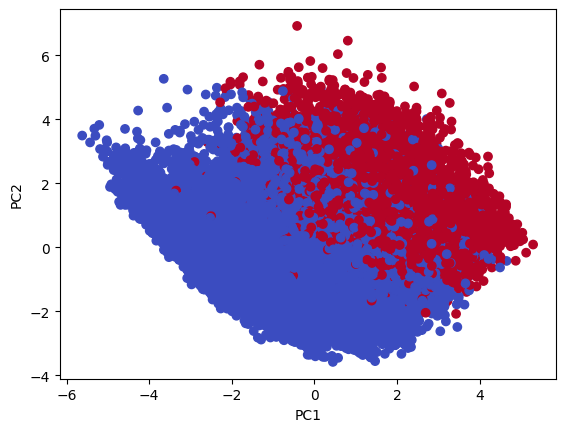

In [9]:
from sklearn.decomposition import PCA
x_re = PCA(n_components=2).fit_transform(x)

plt.scatter(x_re[:, 0], x_re[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [10]:
class RFF(torch.nn.Module):
  def __init__(self, input_dim, num_features, gamma):
    super(RFF, self).__init__()
    self.num_features = num_features
    self.gamma = gamma

    self.w = torch.randn(input_dim, num_features) * ((2*gamma)**0.5)
    self.b = (2*np.pi) * torch.randn(num_features)

  def forward(self, x):
    return torch.sqrt(torch.tensor(2.0 / self.num_features)) * torch.cos((x @ self.w) + self.b)

In [11]:
def RBF_Approx_SVM(x_train, y_train, x_val, gamma, num_features, reg):
  feature_map = RFF(x_train.shape[1], num_features, gamma)

  phi_train = feature_map(x_train)
  phi_val = feature_map(x_val)

  I = torch.eye(num_features)
  w = torch.pinverse(phi_train.T @ phi_train + reg * I) @ (phi_train.T @ y_train)

  y_hat = torch.sign(phi_val @ w)
  return y_hat

In [12]:
x_train = torch.tensor(x_train.values, dtype=torch.float32)
x_val = torch.tensor(x_val.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

gamma = 1
num_features = 5000
reg = 0.3
y_hat = RBF_Approx_SVM(x_train, y_train, x_val, gamma, num_features, reg)
y_hat = ((y_hat + 1) / 2).long()

acc = (y_hat == y_val).float().mean()
print(f"Accuracy: {acc.item()}")

Accuracy: 0.5823324918746948


In [13]:
x_final = torch.tensor(final.values, dtype=torch.float32)
y_hat_final = RBF_Approx_SVM(x_train, y_train, x_final, gamma, num_features, reg)
y_hat_final = ((y_hat_final + 1) / 2).long()

y_hat = pd.DataFrame(y_hat_final)
summarize = pd.concat([id_final, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
print(summarize['loan_status'].unique())
summarize

[0 1]


,id,loan_status
0,31641,0
1,31642,1
2,31643,0
3,31644,1
4,31645,1
...,...,...
7905,39546,0
7906,39547,0
7907,39548,0
7908,39549,1
